Belajar Pengembangan Machine Learning<br>
Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series<br>
Nama  : Yagy Christoper Sumule<br>
Email : yagybatman@gmail.com<br>
Sumber Data: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
data_hour = pd.read_csv('hour.csv')
data_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
data_hour.shape

(17379, 17)

In [4]:
data_hour.isnull().values.any()

False

In [5]:
mnth =  data_hour['mnth'].values
cnt = data_hour['cnt'].values

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mnth, cnt, test_size=0.2, 
                                                    random_state=0, shuffle=False)
print(len(X_train), len(X_test))

13903 3476


In [8]:
x_train_set = windowed_dataset(X_train, window_size=60, batch_size=80, shuffle_buffer=1000)
x_test_set = windowed_dataset(X_test, window_size=60, batch_size=80, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

learning_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
threshold_mae = (data_hour['cnt'].max() - data_hour['cnt'].min()) * 10 / 100
print(threshold_mae)

97.6


In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      self.model.stop_training = True
      print("\nModel MAE < 10% of data scale")
callbacks = myCallback()

In [21]:
tf.keras.backend.set_floatx('float64')
history = model.fit(x_train_set, epochs=50, validation_data=x_test_set, callbacks=[callbacks])

Epoch 1/50
    174/Unknown - 22s 126ms/step - loss: 6.1145 - mae: 6.6048
Model MAE < 10% of data scale
174/174 [==============================] - 24s 139ms/step - loss: 6.1145 - mae: 6.6048 - val_loss: 9.8070 - val_mae: 10.3035


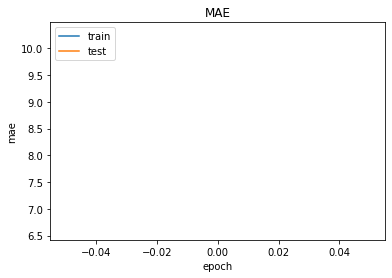

In [22]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

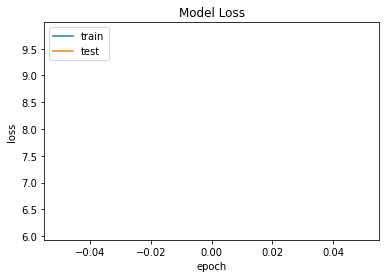

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()